In [ ]:
!pip install tensorflow-gpu

In [ ]:
#install two modules to visualize the network
!pip install pydot
!pip install graphviz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/DRIVE/training/images/21_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/22_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/23_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/24_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/25_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/26_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/27_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/28_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/29_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/30_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/31_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/

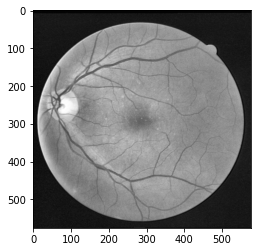

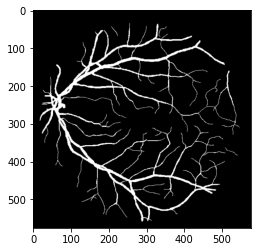

patches per full image: 1000
X_train shape: (20000, 64, 64, 1)
Y_train shape: (20000, 64, 64)
X_train shape: (20000, 1, 64, 64, 1)
Y_train shape: (20000, 4096)
Y_train shape: (20000, 4096, 1)
Y_train shape: (20000, 4096, 2)
X_train shape: (20000, 1, 64, 64, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 64, 64)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 64)   0           conv2d[0][0]                     
_______________________________

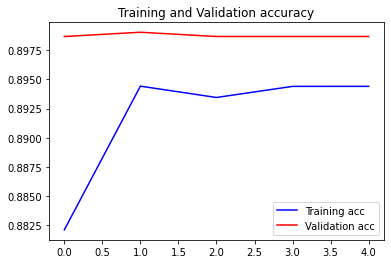

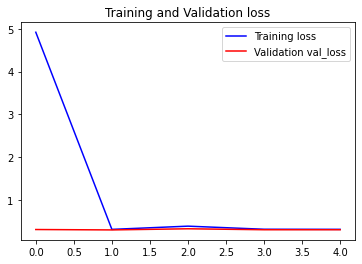

In [ ]:
import matplotlib.pyplot as plt
import sys
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from util import *
from unet import *
from pre_processing import *

if __name__ == '__main__':

    # parameters and paths
    # DRIVE resize:(576, 576)
    # HRF resize:(2920, 2920)
    # IOSTAR resize:(1024, 1024)
    resize_height, resize_width = (576, 576)
    # DRIVE patch size:48
    # HRF patch size:292
    # IOSTAR resize:64
    dx = 64
    # dataset option: DRIVE, HRF and IOSTAR
    dataset = "DRIVE"
    img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
    label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

    # read the data and resize them
    imglst,images = read_image_and_name(img_path)
    labellst,labels = read_label_and_name(label_path)
    imgs_resize = resize(images,resize_height,resize_width)
    labels_resize = resize(labels,resize_height,resize_width)

    # convert the list imgs and manuals to the numpy array
    X_train = np.array(imgs_resize)
    Y_train = np.array(labels_resize)
    print(X_train.shape)
    print(Y_train.shape)

    # do the standardization to the image, each pixel value will be
    # restricted within 0 to 1
    X_train = X_train.astype('float32')/255
    Y_train = Y_train.astype('float32')/255

    # do the pre-processing operations to the training images
    X_train = my_PreProc(X_train)

    print(X_train.shape)
    plt.figure()
    plt.imshow(X_train[0,:,:,0],'gray')
    plt.show()

    plt.figure()
    plt.imshow(Y_train[0,:,:],'gray')
    plt.show()

    patches_num = 1000;

    # crop training images
    X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*X_train.shape[0])
    print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
    print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)


    # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
    X_train = X_train[:,np.newaxis, ...]
    print('X_train shape: '+str(X_train.shape))
    # change the shape of Y_train, make it become (2880,2304), keep the first dimension
    # unchanged, merge other dimensions
    Y_train = Y_train.reshape(Y_train.shape[0],-1)
    print('Y_train shape: '+str(Y_train.shape))
    # increase one dimension, make it become (2880,2304,1)
    Y_train =Y_train[..., np.newaxis]
    print('Y_train shape: '+str(Y_train.shape))
    temp = 1 - Y_train
    # make it become (2880,2304,2)
    Y_train = np.concatenate([Y_train, temp], axis=2)
    print('Y_train shape: '+str(Y_train.shape))
    print('X_train shape: '+str(X_train.shape))

    
    # model is gained
    n_label = 2    #number of classes 
    model = att_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

    #set early stopping to prevent overfit
    early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)
    
    model.summary()  # output the calculation process of parameter Param
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer,early_stopping])
    # draw corresponding loss figures
    epochs = range(len(history.history['accuracy']))
    plt.figure()
    plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
    plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_accuracy.jpg')

    plt.figure()
    plt.plot(epochs,history.history['loss'],'b',label='Training loss')
    plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_loss.jpg')

    plot_model(model,to_file='attention_model.png',show_shapes=True,show_layer_names=True)

    print('ok')
    
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/DRIVE/training/images/21_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/22_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/23_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/24_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/25_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/26_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/27_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/28_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/29_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/30_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/31_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/

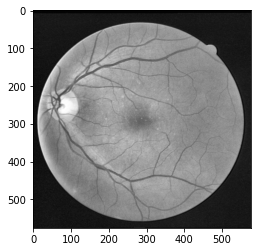

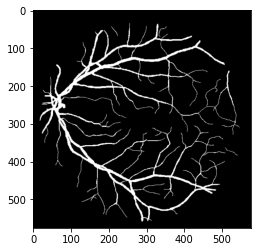

patches per full image: 1000
X_train shape: (20000, 64, 64, 1)
Y_train shape: (20000, 64, 64)
X_train shape: (20000, 1, 64, 64, 1)
Y_train shape: (20000, 4096)
Y_train shape: (20000, 4096, 1)
Y_train shape: (20000, 4096, 2)
X_train shape: (20000, 1, 64, 64, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 64, 64)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 64, 64)   320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 32, 64, 64)   0           conv2d_11[0][0]                  
_____________________________

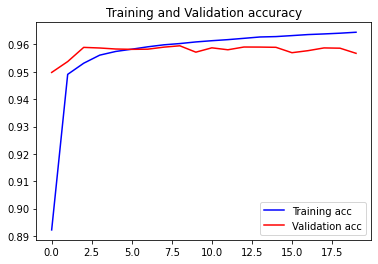

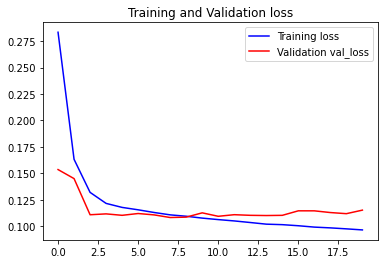

In [ ]:
import matplotlib.pyplot as plt
import sys
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from util import *
from unet import *
from pre_processing import *

if __name__ == '__main__':

    # parameters and paths
    # DRIVE resize:(576, 576)
    # HRF resize:(2920, 2920)
    # IOSTAR resize:(1024, 1024)
    resize_height, resize_width = (576, 576)
    # DRIVE patch size:48
    # HRF patch size:292
    # IOSTAR resize:64
    dx = 64
    # dataset option: DRIVE, HRF and IOSTAR
    dataset = "DRIVE"
    img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
    label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

    # read the data and resize them
    imglst,images = read_image_and_name(img_path)
    labellst,labels = read_label_and_name(label_path)
    imgs_resize = resize(images,resize_height,resize_width)
    labels_resize = resize(labels,resize_height,resize_width)

    # convert the list imgs and manuals to the numpy array
    X_train = np.array(imgs_resize)
    Y_train = np.array(labels_resize)
    print(X_train.shape)
    print(Y_train.shape)

    # do the standardization to the image, each pixel value will be
    # restricted within 0 to 1
    X_train = X_train.astype('float32')/255
    Y_train = Y_train.astype('float32')/255

    # do the pre-processing operations to the training images
    X_train = my_PreProc(X_train)

    print(X_train.shape)
    plt.figure()
    plt.imshow(X_train[0,:,:,0],'gray')
    plt.show()

    plt.figure()
    plt.imshow(Y_train[0,:,:],'gray')
    plt.show()

    patches_num = 1000;

    # crop training images
    X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*X_train.shape[0])
    print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
    print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)


    # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
    X_train = X_train[:,np.newaxis, ...]
    print('X_train shape: '+str(X_train.shape))
    # change the shape of Y_train, make it become (2880,2304), keep the first dimension
    # unchanged, merge other dimensions
    Y_train = Y_train.reshape(Y_train.shape[0],-1)
    print('Y_train shape: '+str(Y_train.shape))
    # increase one dimension, make it become (2880,2304,1)
    Y_train =Y_train[..., np.newaxis]
    print('Y_train shape: '+str(Y_train.shape))
    temp = 1 - Y_train
    # make it become (2880,2304,2)
    Y_train = np.concatenate([Y_train, temp], axis=2)
    print('Y_train shape: '+str(Y_train.shape))
    print('X_train shape: '+str(X_train.shape))

    
    # model is gained
    n_label = 2    #number of classes 
    model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

    #set early stopping to prevent overfit
    early_stopping = EarlyStopping(monitor='loss',patience=3,verbose=2)
    
    model.summary()  # output the calculation process of parameter Param
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer,early_stopping])
    # draw corresponding loss figures
    epochs = range(len(history.history['accuracy']))
    plt.figure()
    plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
    plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_accuracy.jpg')

    plt.figure()
    plt.plot(epochs,history.history['loss'],'b',label='Training loss')
    plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_loss.jpg')

    plot_model(model,to_file='unet_model.png',show_shapes=True,show_layer_names=True)

    print('ok')

In [ ]:
#use the whole image to make experiments
import matplotlib.pyplot as plt
import sys
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from util import *
from unet import *
from pre_processing import *

if __name__ == '__main__':

    # parameters and paths
    # DRIVE resize:(576, 576)
    # HRF resize:(2920, 2920)
    # IOSTAR resize:(1024, 1024)
    resize_height, resize_width = (576, 576)
    # DRIVE patch size:48
    # HRF patch size:292
    # IOSTAR resize:64
    dx = 64
    # dataset option: DRIVE, HRF and IOSTAR
    dataset = "DRIVE"
    img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
    label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

    # read the data and resize them
    imglst,images = read_image_and_name(img_path)
    labellst,labels = read_label_and_name(label_path)
    imgs_resize = resize(images,resize_height,resize_width)
    labels_resize = resize(labels,resize_height,resize_width)

    # convert the list imgs and manuals to the numpy array
    X_train = np.array(imgs_resize)
    Y_train = np.array(labels_resize)
    print(X_train.shape)
    print(Y_train.shape)

    # do the standardization to the image, each pixel value will be
    # restricted within 0 to 1
    X_train = X_train.astype('float32')/255
    Y_train = Y_train.astype('float32')/255

    # do the pre-processing operations to the training images
    X_train = my_PreProc(X_train)

    print(X_train.shape)
    plt.figure()
    plt.imshow(X_train[0,:,:,0],'gray')
    plt.show()

    plt.figure()
    plt.imshow(Y_train[0,:,:],'gray')
    plt.show()

    patches_num = 1000;

    # crop training images
    X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*X_train.shape[0])
    print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
    print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)


    # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
    X_train = X_train[:,np.newaxis, ...]
    print('X_train shape: '+str(X_train.shape))
    # change the shape of Y_train, make it become (2880,2304), keep the first dimension
    # unchanged, merge other dimensions
    Y_train = Y_train.reshape(Y_train.shape[0],-1)
    print('Y_train shape: '+str(Y_train.shape))
    # increase one dimension, make it become (2880,2304,1)
    Y_train =Y_train[..., np.newaxis]
    print('Y_train shape: '+str(Y_train.shape))
    temp = 1 - Y_train
    # make it become (2880,2304,2)
    Y_train = np.concatenate([Y_train, temp], axis=2)
    print('Y_train shape: '+str(Y_train.shape))
    print('X_train shape: '+str(X_train.shape))

    
    # model is gained
    n_label = 2    #number of classes 
    model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

    #set early stopping to prevent overfit
    early_stopping = EarlyStopping(monitor='loss',patience=3,verbose=2)
    
    model.summary()  # output the calculation process of parameter Param
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer,early_stopping])
    # draw corresponding loss figures
    epochs = range(len(history.history['accuracy']))
    plt.figure()
    plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
    plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_accuracy.jpg')

    plt.figure()
    plt.plot(epochs,history.history['loss'],'b',label='Training loss')
    plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_loss.jpg')

    plot_model(model,to_file='unet_model.png',show_shapes=True,show_layer_names=True)

    print('ok')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 01_OSC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 02_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 03_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 05_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 06_ODN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 08_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 09_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 10_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 13_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 15_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 16_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/trai

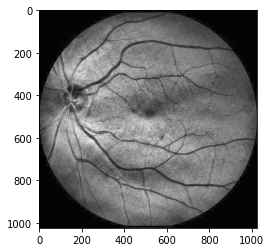

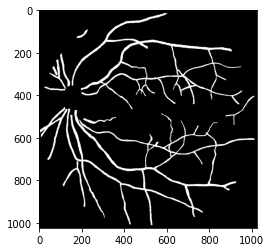

X_train shape: (61440, 16, 16, 1)
Y_train shape: (61440, 16, 16)
X_train shape: (61440, 1, 16, 16, 1)
Y_train shape: (61440, 256)
Y_train shape: (61440, 256, 1)
Y_train shape: (61440, 256, 2)
X_train shape: (61440, 1, 16, 16, 1)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1, 16, 16)]  0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 32, 16, 16)   320         input_9[0][0]                    
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 32, 16, 16)   0           conv2d_80[0][0]                  
_____________________________________________________________

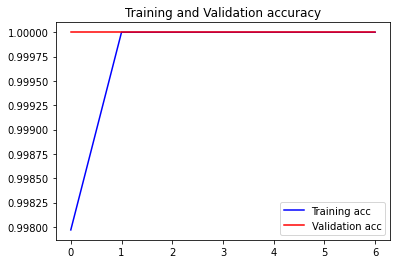

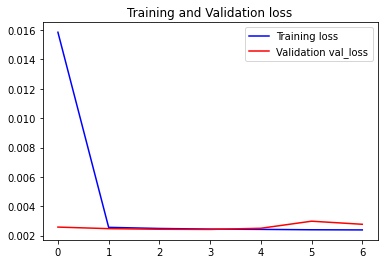

In [ ]:
import matplotlib.pyplot as plt
import sys
from google.colab import drive
from keras.callbacks import EarlyStopping
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from util import *
from unet import *
from pre_processing import *

if __name__ == '__main__':

    # parameters and paths
    # DRIVE resize:(576, 576)
    # HRF resize:(2920, 2920)
    # IOSTAR resize:(1024, 1024)
    resize_height, resize_width = (1024, 1024)
    # DRIVE patch size:48
    # HRF patch size:292
    # IOSTAR resize:64
    dx = 16
    # dataset option: DRIVE, HRF and IOSTAR
    dataset = "IOSTAR"
    img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
    label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

    # read the data and resize them
    imglst,images = read_image_and_name(img_path)
    labellst,labels = read_label_and_name(label_path)
    imgs_resize = resize(images,resize_height,resize_width)
    labels_resize = resize(labels,resize_height,resize_width)

    # convert the list imgs and manuals to the numpy array
    X_train = np.array(imgs_resize)
    Y_train = np.array(labels_resize)
    print(X_train.shape)
    print(Y_train.shape)

    # do the standardization to the image, each pixel value will be
    # restricted within 0 to 1
    X_train = X_train.astype('float32')/255
    Y_train = Y_train.astype('float32')/255

    # do the pre-processing operations to the training images
    X_train = my_PreProc(X_train)

    print(X_train.shape)
    plt.figure()
    plt.imshow(X_train[0,:,:,0],'gray')
    plt.show()

    plt.figure()
    plt.imshow(Y_train[0,:,:],'gray')
    plt.show()


    # crop training images
    X_train = crop(X_train,dx)
    Y_train = crop(Y_train,dx)
    print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
    print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)


    # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
    X_train = X_train[:,np.newaxis, ...]
    print('X_train shape: '+str(X_train.shape))
    # change the shape of Y_train, make it become (2880,2304), keep the first dimension
    # unchanged, merge other dimensions
    Y_train = Y_train.reshape(Y_train.shape[0],-1)
    print('Y_train shape: '+str(Y_train.shape))
    # increase one dimension, make it become (2880,2304,1)
    Y_train =Y_train[..., np.newaxis]
    print('Y_train shape: '+str(Y_train.shape))
    temp = 1 - Y_train
    # make it become (2880,2304,2)
    Y_train = np.concatenate([Y_train, temp], axis=2)
    print('Y_train shape: '+str(Y_train.shape))
    print('X_train shape: '+str(X_train.shape))

    
    # model is gained
    n_label = 2    #number of classes 
    model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

    #set early stopping to prevent overfit
    early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)
    
    model.summary()  # output the calculation process of parameter Param
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer,early_stopping])
    # draw corresponding loss figures
    epochs = range(len(history.history['accuracy']))
    plt.figure()
    plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
    plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_accuracy.jpg')

    plt.figure()
    plt.plot(epochs,history.history['loss'],'b',label='Training loss')
    plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_loss.jpg')

    print('ok')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 01_OSC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 02_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 03_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 05_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 06_ODN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 08_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 09_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 10_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 13_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 15_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 16_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/trai

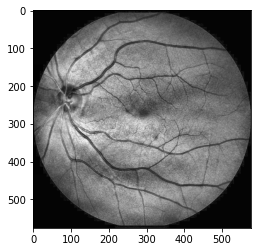

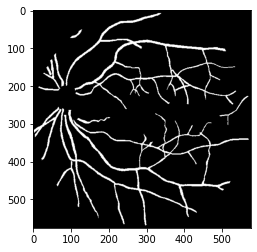

X_train shape: (2160, 48, 48, 1)
Y_train shape: (2160, 48, 48)
X_train shape: (2160, 1, 48, 48, 1)
Y_train shape: (2160, 2304)
Y_train shape: (2160, 2304, 1)
Y_train shape: (2160, 2304, 2)
X_train shape: (2160, 1, 48, 48, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1, 48, 48)]  0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 32, 48, 48)   320         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_32 (Dropout)            (None, 32, 48, 48)   0           conv2d_69[0][0]                  
_________________________________________________________________

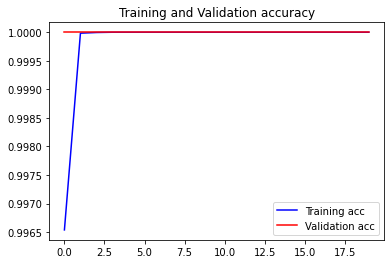

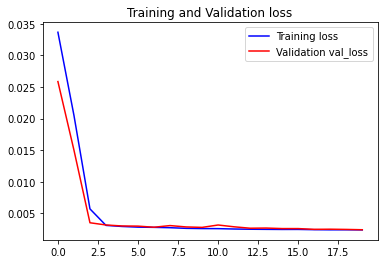

In [ ]:
import matplotlib.pyplot as plt
import sys
from google.colab import drive
from keras.callbacks import EarlyStopping
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from util import *
from unet import *
from pre_processing import *

if __name__ == '__main__':

    # parameters and paths
    # DRIVE resize:(576, 576)
    # HRF resize:(2920, 2920)
    # IOSTAR resize:(1024, 1024)
    resize_height, resize_width = (576, 576)
    # DRIVE patch size:48
    # HRF patch size:292
    # IOSTAR resize:64
    dx = 48
    # dataset option: DRIVE, HRF and IOSTAR
    dataset = "IOSTAR"
    img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
    label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

    # read the data and resize them
    imglst,images = read_image_and_name(img_path)
    labellst,labels = read_label_and_name(label_path)
    imgs_resize = resize(images,resize_height,resize_width)
    labels_resize = resize(labels,resize_height,resize_width)

    # convert the list imgs and manuals to the numpy array
    X_train = np.array(imgs_resize)
    Y_train = np.array(labels_resize)
    print(X_train.shape)
    print(Y_train.shape)

    # do the standardization to the image, each pixel value will be
    # restricted within 0 to 1
    X_train = X_train.astype('float32')/255
    Y_train = Y_train.astype('float32')/255

    # do the pre-processing operations to the training images
    X_train = my_PreProc(X_train)

    print(X_train.shape)
    plt.figure()
    plt.imshow(X_train[0,:,:,0],'gray')
    plt.show()

    plt.figure()
    plt.imshow(Y_train[0,:,:],'gray')
    plt.show()


    # crop training images
    X_train = crop(X_train,dx)
    Y_train = crop(Y_train,dx)
    print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
    print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)


    # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
    X_train = X_train[:,np.newaxis, ...]
    print('X_train shape: '+str(X_train.shape))
    # change the shape of Y_train, make it become (2880,2304), keep the first dimension
    # unchanged, merge other dimensions
    Y_train = Y_train.reshape(Y_train.shape[0],-1)
    print('Y_train shape: '+str(Y_train.shape))
    # increase one dimension, make it become (2880,2304,1)
    Y_train =Y_train[..., np.newaxis]
    print('Y_train shape: '+str(Y_train.shape))
    temp = 1 - Y_train
    # make it become (2880,2304,2)
    Y_train = np.concatenate([Y_train, temp], axis=2)
    print('Y_train shape: '+str(Y_train.shape))
    print('X_train shape: '+str(X_train.shape))

    
    # model is gained
    n_label = 2    #number of classes 
    model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

    #set early stopping to prevent overfit
    early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)
    
    model.summary()  # output the calculation process of parameter Param
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer,early_stopping])
    # draw corresponding loss figures
    epochs = range(len(history.history['accuracy']))
    plt.figure()
    plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
    plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_accuracy.jpg')

    plt.figure()
    plt.plot(epochs,history.history['loss'],'b',label='Training loss')
    plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_loss.jpg')

    print('ok')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/HRF/training/images/01_dr.JPG', '/content/drive/MyDrive/MyProject/HRF/training/images/01_g.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/01_h.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/02_dr.JPG', '/content/drive/MyDrive/MyProject/HRF/training/images/02_g.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/02_h.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/03_dr.JPG', '/content/drive/MyDrive/MyProject/HRF/training/images/03_g.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/03_h.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/04_dr.JPG', '/content/drive/MyDrive/MyProject/HRF/training/images/04_g.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/04_h.jpg', '/content/drive/MyDrive/MyProject/HRF/training/images/05_dr.JPG', '/content/drive/MyDr

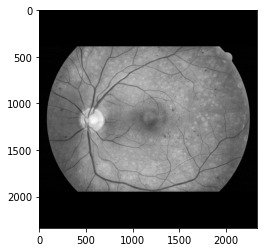

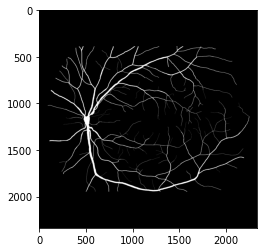

X_train shape: (117238, 32, 32, 1)
Y_train shape: (117238, 32, 32)
X_train shape: (117238, 1, 32, 32, 1)
Y_train shape: (117238, 1024)
Y_train shape: (117238, 1024, 1)
Y_train shape: (117238, 1024, 2)
X_train shape: (117238, 1, 32, 32, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 32, 32)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 32, 32, 32)   0           conv2d_6[0][0]                   
_____________________________________________________

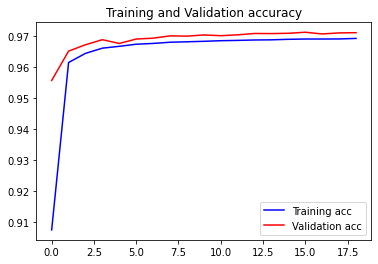

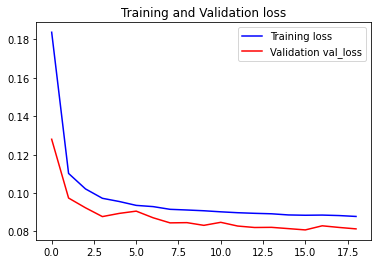

In [ ]:
import matplotlib.pyplot as plt
import sys
import cv2
from google.colab import drive
from keras.callbacks import EarlyStopping
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from util import *
from unet import *
from pre_processing import *

if __name__ == '__main__':

    # parameters and paths
    # DRIVE resize:(576, 576)
    # HRF resize:(2336, 2336)
    # IOSTAR resize:(1024, 1024)
    resize_height, resize_width = (2336, 2336)
    # DRIVE patch size:48
    # HRF patch size:292
    # IOSTAR resize:64
    dx = 32
    # dataset option: DRIVE, HRF and IOSTAR
    dataset = "HRF"
    img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
    label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

    # read the data and resize them
    imglst,images = read_image_and_name(img_path)
    labellst,labels = read_label_and_name(label_path)
    imgs_resize = resize2SquareKeepingAspectRation(images,resize_height,cv2.INTER_AREA)
    labels_resize = resize2SquareKeepingAspectRation(labels,resize_height,cv2.INTER_AREA)

    # convert the list imgs and manuals to the numpy array
    X_train = np.array(imgs_resize)
    Y_train = np.array(labels_resize)
    print(X_train.shape)
    print(Y_train.shape)

    # do the standardization to the image, each pixel value will be
    # restricted within 0 to 1
    X_train = X_train.astype('float32')/255
    Y_train = Y_train.astype('float32')/255

    # do the pre-processing operations to the training images
    X_train = my_PreProc(X_train)

    print(X_train.shape)
    plt.figure()
    plt.imshow(X_train[0,:,:,0],'gray')
    plt.show()

    plt.figure()
    plt.imshow(Y_train[0,:,:],'gray')
    plt.show()

    
    # crop training images
    X_train = crop(X_train,dx)
    Y_train = crop(Y_train,dx)
    print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
    print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)


    # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
    X_train = X_train[:,np.newaxis, ...]
    print('X_train shape: '+str(X_train.shape))
    # change the shape of Y_train, make it become (2880,2304), keep the first dimension
    # unchanged, merge other dimensions
    Y_train = Y_train.reshape(Y_train.shape[0],-1)
    print('Y_train shape: '+str(Y_train.shape))
    # increase one dimension, make it become (2880,2304,1)
    Y_train =Y_train[..., np.newaxis]
    print('Y_train shape: '+str(Y_train.shape))
    temp = 1 - Y_train
    # make it become (2880,2304,2)
    Y_train = np.concatenate([Y_train, temp], axis=2)
    print('Y_train shape: '+str(Y_train.shape))
    print('X_train shape: '+str(X_train.shape))

    
    # model is gained
    n_label = 2    #number of classes 
    model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

    #set early stopping to prevent overfit
    early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)
    
    model.summary()  # output the calculation process of parameter Param
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer,early_stopping])
    # draw corresponding loss figures
    epochs = range(len(history.history['accuracy']))
    plt.figure()
    plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
    plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_accuracy.jpg')

    plt.figure()
    plt.plot(epochs,history.history['loss'],'b',label='Training loss')
    plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_loss.jpg')

    print('ok')
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/DRIVE/training/images/21_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/22_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/23_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/24_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/25_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/26_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/27_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/28_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/29_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/30_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/31_training.tif', '/content/drive/MyDrive/MyProject/DRIVE/training/images/

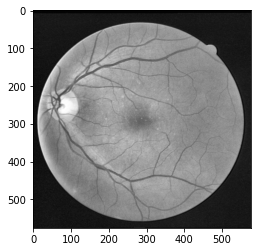

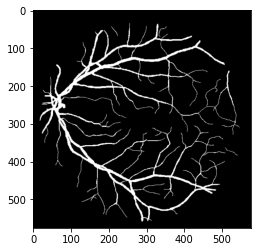

X_train shape: (2880, 48, 48, 1)
Y_train shape: (2880, 48, 48)
X_train shape: (2880, 1, 48, 48, 1)
Y_train shape: (2880, 2304)
Y_train shape: (2880, 2304, 1)
Y_train shape: (2880, 2304, 2)
X_train shape: (2880, 1, 48, 48, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 48, 48)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 48, 48)   320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 32, 48, 48)   0           conv2d_11[0][0]                  
_________________________________________________________________

In [ ]:
import matplotlib.pyplot as plt
import sys
from google.colab import drive
from keras.callbacks import EarlyStopping
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules

from util import *
from unet import *
from pre_processing import *

if __name__ == '__main__':

    # parameters and paths
    # DRIVE resize:(576, 576)
    # HRF resize:(2920, 2920)
    # IOSTAR resize:(1024, 1024)
    resize_height, resize_width = (576, 576)
    # DRIVE patch size:48
    # HRF patch size:292
    # IOSTAR resize:64
    dx = 48
    # dataset option: DRIVE, HRF and IOSTAR
    dataset = "DRIVE"
    img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
    label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

    # read the data and resize them
    imglst,images = read_image_and_name(img_path)
    labellst,labels = read_label_and_name(label_path)
    imgs_resize = resize(images,resize_height,resize_width)
    labels_resize = resize(labels,resize_height,resize_width)

    # convert the list imgs and manuals to the numpy array
    X_train = np.array(imgs_resize)
    Y_train = np.array(labels_resize)
    print(X_train.shape)
    print(Y_train.shape)

    # do the standardization to the image, each pixel value will be
    # restricted within 0 to 1
    X_train = X_train.astype('float32')/255
    Y_train = Y_train.astype('float32')/255

    # do the pre-processing operations to the training images
    X_train = my_PreProc(X_train)

    print(X_train.shape)
    plt.figure()
    plt.imshow(X_train[0,:,:,0],'gray')
    plt.show()

    plt.figure()
    plt.imshow(Y_train[0,:,:],'gray')
    plt.show()


    # crop training images
    X_train = crop(X_train,dx)
    Y_train = crop(Y_train,dx)
    print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
    print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)


    # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
    X_train = X_train[:,np.newaxis, ...]
    print('X_train shape: '+str(X_train.shape))
    # change the shape of Y_train, make it become (2880,2304), keep the first dimension
    # unchanged, merge other dimensions
    Y_train = Y_train.reshape(Y_train.shape[0],-1)
    print('Y_train shape: '+str(Y_train.shape))
    # increase one dimension, make it become (2880,2304,1)
    Y_train =Y_train[..., np.newaxis]
    print('Y_train shape: '+str(Y_train.shape))
    temp = 1 - Y_train
    # make it become (2880,2304,2)
    Y_train = np.concatenate([Y_train, temp], axis=2)
    print('Y_train shape: '+str(Y_train.shape))
    print('X_train shape: '+str(X_train.shape))

    
    # model is gained
    n_label = 2    #number of classes 
    model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

    #set early stopping to prevent overfit
    early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)
    
    model.summary()  # output the calculation process of parameter Param

    for layer in model.layers[:8]:
        layer.trainable=False
        print (layer)
        print ("these layers wont be trained")
    '''
    for layer in model.layers[17:25]:
        layer.trainable = False
        print (layer)
        print ("these layers wont be trained")
    '''

    '''
    checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_best_weights.h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train,Y_train,batch_size=64,epochs=20,verbose=2,shuffle=True,validation_split=0.2,callbacks=[checkpointer,early_stopping])
    # draw corresponding loss figures
    epochs = range(len(history.history['accuracy']))
    plt.figure()
    plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
    plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_accuracy.jpg')

    plt.figure()
    plt.plot(epochs,history.history['loss'],'b',label='Training loss')
    plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/MyProject/'+dataset+'/'+dataset+'_model_loss.jpg')

    print('ok')
    '''
    
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 01_OSC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 02_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 03_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 05_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 06_ODN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 08_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 09_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 10_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 13_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 15_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 16_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/trai

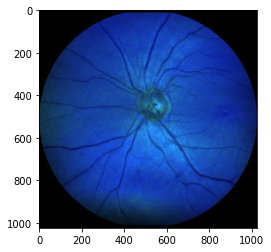

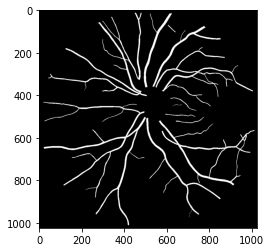

(2, 1024, 1024, 3)
(2, 1024, 1024)
2
(2, 1024, 1024, 1)


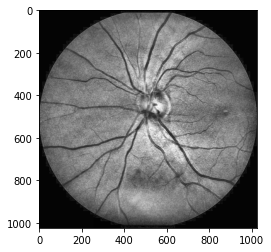

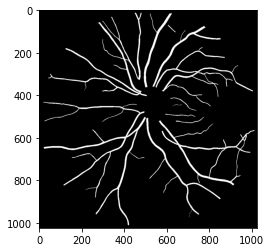

X_train shape: (2, 1024, 1024, 1)
Y_train shape: (2, 1024, 1024)
patches per full image: 1000
X_train shape: (2000, 128, 128, 1)
Y_train shape: (2000, 128, 128)


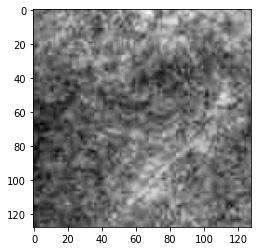

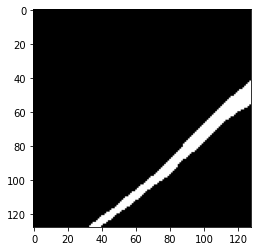

X_train shape: (2000, 1, 128, 128, 1)
Y_train shape: (2000, 16384)
Y_train shape: (2000, 16384, 1)
Y_train shape: (2000, 16384, 2)
X_train shape: (2000, 1, 128, 128, 1)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 128, 128) 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 128, 128) 320         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 32, 128, 128) 512         conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)    

KeyboardInterrupt: ignored

In [ ]:
#margin sampling
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import random
import numpy as np
import heapq
import pickle

from google.colab import drive
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules
from keras.callbacks import EarlyStopping
from util import *
from unet import *
from pre_processing import *
from sklearn.model_selection import train_test_split
from keras import backend as K

def margin_sampling(probability_map1, probability_map2):
  deduction = probability_map1 - probability_map2
  #print(deduction.shape)
  return np.round(np.mean(abs(deduction)),6)

def least_confidence(probability_map1, probability_map2):
  #next step is equal to 1 - np.minimumprobability_map1, probability_map2)
  least_confidence = np.minimum(probability_map1, probability_map2) 
  return np.round(np.mean(abs(least_confidence)),6)

def entropy_sampling(probability_map1, probability_map2):
  #base = 10
  item1 = np.dot(probability_map1,np.log10(probability_map1))
  item2 = np.dot(probability_map2,np.log10(probability_map2))
  sum_of_item = -(item1+item2)
  return np.mean(sum_of_item)

def EGL(probability_map1, probability_map2, grads_norm):
  item1 = probability_map1 * grads_norm
  item2 = probability_map2 * grads_norm
  item = item1 + item2
  mean_of_gradients = np.mean(item)
  return mean_of_gradients
  
if __name__ == '__main__':

  # parameters and paths
  # DRIVE resize:(576, 576)
  # HRF resize:(2920, 2920)
  # IOSTAR resize:(1024, 1024)
  resize_height, resize_width = (1024, 1024)
  # DRIVE patch size:48
  # HRF patch size:292
  # IOSTAR resize:64
  dx = 128
  # dataset option: DRIVE, HRF and IOSTAR
  dataset = "IOSTAR"

  img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
  label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

  # read the data and resize them
  imglst,images = read_image_and_name(img_path)
  labellst,labels = read_label_and_name(label_path)
  
  # pre selected annotated samples by active learning(inside 20 training images)
  # range [2, 6, 10, 14, 18, 20]
  selected_image_nums = [2, 6, 10, 14, 18, 22]  #it could be gained by percent as well, like int(0.5*len(data))

  #set the name of method will be used, selective options
  #margin_sampling, least_confidence, entropy_sampling, excepted_gradient_length, random_sampling
  methods = ["margin_sampling", "least_confidence", "entropy_sampling", "excepted_gradient_length", "random_sampling"]

  for method in methods:
    for selected_image_num in selected_image_nums:

      # randomly selected N(stored inside the variable imglst) samples from the training dataset
      print(len(images))
      image_index = [i for i in range(len(images))];
      sample_index = random.sample(image_index, selected_image_num);
      print(sample_index)
      sample_data = [images[i] for i in sample_index]
      sample_label = [labels[i] for i in sample_index]
      
      #check if the order of images and labels is not corresponding
      plt.figure()
      plt.imshow(sample_data[1])
      plt.show()

      plt.figure()
      plt.imshow(sample_label[1],'gray')
      plt.show()

      imgs_resize = resize(sample_data,resize_height,resize_width)
      labels_resize = resize(sample_label,resize_height,resize_width)

      # convert the list imgs and manuals to the numpy array
      X_train = np.array(imgs_resize)
      Y_train = np.array(labels_resize)
      print(X_train.shape)
      print(Y_train.shape)


      # do the standardization to the image, each pixel value will be
      # restricted within 0 to 1
      X_train = X_train.astype('float32')/255
      Y_train = Y_train.astype('float32')/255

      # do the pre-processing operations to the training images
      X_train = my_PreProc(X_train)

      print(X_train.shape)
      plt.figure()
      plt.imshow(X_train[1,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[1,:,:],'gray')
      plt.show()


      print('X_train shape: ' + str(X_train.shape))  # X_train(2880,48,48)
      print('Y_train shape: ' + str(Y_train.shape))  # Y_train(2880,48,48)

      # crop training images
      patches_num = 400;       #required patches num  1000

      X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*selected_image_num)
      print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
      print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)
      
      
      #Save a sample of what you're feeding to the neural network
      N_sample = min(X_train.shape[0],40)
      temp_Ytrain = Y_train[...,np.newaxis]
      #visualize(,'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(X_train[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(temp_Ytrain[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_output_imgs')

      plt.figure()
      plt.imshow(X_train[12,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[12,:,:],'gray')
      plt.show()
      
      # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
      X_train = X_train[:,np.newaxis, ...]
      print('X_train shape: '+str(X_train.shape))
      # change the shape of Y_train, make it become (2880,2304), keep the first dimension
      # unchanged, merge other dimensions
      Y_train = Y_train.reshape(Y_train.shape[0],-1)
      print('Y_train shape: '+str(Y_train.shape))
      # increase one dimension, make it become (2880,2304,1)
      Y_train =Y_train[..., np.newaxis]
      print('Y_train shape: '+str(Y_train.shape))
      temp = 1 - Y_train
      # make it become (2880,2304,2)
      Y_train = np.concatenate([Y_train, temp], axis=2)
      print('Y_train shape: '+str(Y_train.shape))
      print('X_train shape: '+str(X_train.shape))
      
      
      # model is gained
      n_label = 2   #number of classes
      model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

      #set early stopping to prevent overfit
      early_stopping = EarlyStopping(monitor='loss',patience=3,verbose=2)
      
      model.summary()  # output the calculation process of parameter Param
      checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_image_num)+
                                      ').h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
      
      model.compile(optimizer=Adam(lr=0.0005),loss='categorical_crossentropy',metrics=['accuracy']) 


      #split 80% for training and 20% for validation
      seed = 7
      np.random.seed(seed)
      X_trainset, X_testset, Y_trainset, Y_testset = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

      history1 = model.fit(X_trainset,Y_trainset,batch_size=64,epochs=10,verbose=2,shuffle=True,validation_data=(X_testset, Y_testset),callbacks=[checkpointer,early_stopping])
      
      # use the uncertainty and fine-tuning to train this model
      training_samples_num = selected_image_num * patches_num
      # patches number extracted from unlabeled images
      unlabeled_patches_num = 100

      active_indice = [i for i in image_index if i not in sample_index]
      print("active_indice:"+str(len(active_indice)))

      final_new_train_samples = X_trainset
      final_new_train_labels = Y_trainset

      epochs = 0

      #start the for-loop from here
      #while len(active_indice) != 0:
      #a = 1
      #while a == 1:

      #a = 1
      while len(active_indice) != 0:
          
        active_image_data = [images[i] for i in active_indice]
        active_image_label = [labels[i] for i in active_indice]

        active_imgs_resize = resize(active_image_data,resize_height,resize_width)
        active_labels_resize = resize(active_image_label,resize_height,resize_width)

        #extract patches from unlabeled images again, take their labels meanwhile
        #convert the list imgs and manuals to the numpy array
        active_X_train = np.array(active_imgs_resize)
        active_Y_train = np.array(active_labels_resize)

        # do the standardization to the image, each pixel value will be
        # restricted within 0 to 1
        active_X_train = active_X_train.astype('float32')/255
        active_Y_train = active_Y_train.astype('float32')/255

        # do the pre-processing operations to the training images
        active_X_train = my_PreProc(active_X_train)
        print('active_X_train shape: '+str(active_X_train.shape)) 
        print('active_Y_train shape: '+str(active_Y_train.shape))
        
        if method is not "random_sampling":
          #active_samples_num = len(active_indice) * unlabeled_patches_num
          sample_confidence = []
          for k in range(active_X_train.shape[0]):   
            list1 = []
            list2 = []
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                list1.append(active_X_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
                list2.append(active_Y_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
            active_prediction_samples = np.array(list1)[:,np.newaxis,...] #increase one dimension, it will become (144,1,48,48)
            active_groundtruth_samples = np.array(list2)[:,np.newaxis,...]
            #print('active_X_train shape: '+str(active_prediction_samples.shape)) 
            #print('active_Y_train shape: '+str(active_Y_train.shape))

            #print(new_X_train.shape)
            Y_pred_train = model.predict(active_prediction_samples)
            #print('predict shape: '+str(Y_pred_train.shape))

            Y_pred1 = Y_pred_train[...,0]
            Y_pred2 = Y_pred_train[...,1]

            probability_map1 = np.zeros((resize_height, resize_width))
            probability_map2 = np.zeros((resize_height, resize_width))

            t = 0
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                temp1 = Y_pred1[t].reshape(dx, dx)
                temp2 = Y_pred2[t].reshape(dx, dx)
                probability_map1[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp1
                probability_map2[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp2
                t = t + 1
            
            probability_map1 = cv2.resize(probability_map1,(resize_height,resize_width))
            probability_map2 = cv2.resize(probability_map2,(resize_height,resize_width))
            
            #output one to see the probability
            #print('probability:'+str(Y_pred_train[1,:,0]))
            #print('probability:'+str(Y_pred_train[1,:,1]))

            #calculate every unannotated image's uncertainty
            #S = np.round(compute_matrix(Y_pred_train, 0, 1, 1),2)
            if method == "margin_sampling":
              S = margin_sampling(probability_map1, probability_map2)
            elif method == "least_confidence":
              S = least_confidence(probability_map1, probability_map2)
            elif method == "entropy_sampling":
              S = entropy_sampling(probability_map1, probability_map2)
            elif method == "excepted_gradient_length":
              real_y = active_groundtruth_samples
              real_y = real_y.reshape(real_y.shape[0],-1)
              real_y = real_y[...,np.newaxis]
              temp = 1 - real_y
              real_y = np.concatenate([real_y, temp], axis=2)
              
              with tf.GradientTape() as tape:
                cce = tf.keras.losses.CategoricalCrossentropy()
                pred_y = model(active_prediction_samples)
                ce_loss = cce(real_y, pred_y)
              
              grads = tape.gradient(ce_loss,model.trainable_variables)
              grads_norm = 0
              #print(len(grads))
              for i in range(len(grads)):
                grads_norm = grads_norm + np.linalg.norm(x=grads[i].numpy().flatten(),ord=2)
              #print(grads_norm)
              S = EGL(probability_map1, probability_map2, grads_norm)

            sample_confidence.append(S)
              

        #print(active_scores)
        print(sample_confidence)

        #find the elements with lowest/highest active scores
        smallest_index = []
        if method == "random_sampling":
          selected_num = 1
          current_active_indice = [i for i in range(len(active_indice))];
          smallest_index = random.sample(current_active_indice, selected_num);
        elif method == "margin_sampling":
          smallest_index = [index for index,value in enumerate(sample_confidence) if value==min(sample_confidence)]
        elif method == "least_confidence":
          smallest_index = [index for index,value in enumerate(sample_confidence) if value==max(sample_confidence)]
        elif method == "entropy_sampling":
          smallest_index = [index for index,value in enumerate(sample_confidence) if value==max(sample_confidence)]
        elif method == "excepted_gradient_length":
          smallest_index = [index for index,value in enumerate(sample_confidence) if value==max(sample_confidence)]
        
        smallest_elements = [active_X_train[i] for i in smallest_index]
        smallest_labels = [active_Y_train[i] for i in smallest_index]

        smallest_elements = resize(smallest_elements,resize_height,resize_width)
        smallest_labels = resize(smallest_labels,resize_height,resize_width)

        smallest_elements = np.array(smallest_elements)
        smallest_labels = np.array(smallest_labels)

        #smallest_elements, smallest_labels = extract_random(smallest_elements, smallest_labels, dx, dx, unlabeled_patches_num*len(smallest_index))
        
        temp_elements = []
        temp_labels = []
        for a, b in zip(smallest_elements, smallest_labels):
          for i in range(resize_height//dx):
            for j in range(resize_width//dx):
              temp_elements.append(a[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
              temp_labels.append(b[i*dx:(i+1)*dx, j*dx:(j+1)*dx])

        smallest_elements = np.array(temp_elements)[:,np.newaxis,...,np.newaxis]
        smallest_labels = np.array(temp_labels)[:,np.newaxis,...,np.newaxis]

        print(smallest_elements.shape)
        print(smallest_labels.shape)

        #smallest_elements = smallest_elements[..., np.newaxis]

        # change the shape of Y_train, make it become (2880,2304), keep the first dimension
        # unchanged, merge other dimensions
        smallest_labels = smallest_labels.reshape(smallest_labels.shape[0],-1)
        print('smallest_labels shape: '+str(smallest_labels.shape))
        # increase one dimension, make it become (2880,2304,1)
        smallest_labels = smallest_labels[..., np.newaxis]
        print('Y_train shape: '+str(Y_train.shape))
        temp = 1 - smallest_labels
        # make it become (2880,2304,2)
        smallest_labels = np.concatenate([smallest_labels, temp], axis=2)

        print(smallest_elements.shape)
        print(smallest_labels.shape)          
        

        new_train_samples = []
        for i in range(final_new_train_samples.shape[0]):
          ori_element = final_new_train_samples[i,...]
          new_train_samples.append(ori_element[np.newaxis,:])
        for j in range(smallest_elements.shape[0]):
          new_element = smallest_elements[j,...]
          new_train_samples.append(new_element[np.newaxis,:])
        final_new_train_samples = np.concatenate(new_train_samples,axis=0)
        
        new_train_labels = []
        for i in range(final_new_train_labels.shape[0]):
          ori_label = final_new_train_labels[i,...]
          new_train_labels.append(ori_label[np.newaxis,:])
        for j in range(smallest_labels.shape[0]):
          new_label = smallest_labels[j,...]
          new_train_labels.append(new_label[np.newaxis,:])
        final_new_train_labels = np.concatenate(new_train_labels,axis=0)

        print('final_new_train_samples shape: '+str(final_new_train_samples.shape))
        print('final_new_train_labels shape: '+str(final_new_train_labels.shape))
      
        # use these 100 the most uncertain samples 
        # to do the fine-tuning to this network
        print("Use the pre trained model for fine tuning")
        print(model.layers)

        for layer in model.layers[:10]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        for layer in model.layers[21:30]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        
        print(len(model.layers))

        #set early stopping to prevent overfit
        #early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)

        #model.summary()  # output the calculation process of parameter Param
        checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_image_num)+
                                      ').h5',verbose=1,monitor='accuracy',mode='auto',save_best_only=True)
        model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
        history2 = model.fit(final_new_train_samples,final_new_train_labels,batch_size=64,epochs=10,verbose=2,shuffle=True,validation_split=0.0,callbacks=[checkpointer,early_stopping]) #,early_stopping

        #update corresponding parameters
        ruleout_list = [active_indice[i] for i in smallest_index]
        active_indice = [x for x in active_indice if x not in ruleout_list]
        print(active_indice)
        active_samples_num = len(active_indice)*patches_num

        # draw corresponding loss figures
        history1.history['accuracy'].extend(history2.history['accuracy'])
        history1.history['loss'].extend(history2.history['loss'])
        
      #print(history1.history['accuracy'])
      #print(history1.history['loss'])

      #mode wb+ readable and writable, and files will be automatically created if they don't exist
      #binary mode
      with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_'+str(selected_image_num)+'.txt','wb+') as file_pi:
        pickle.dump(history1.history, file_pi)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 01_OSC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 02_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 03_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 05_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 06_ODN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 08_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 09_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 10_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 13_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 15_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 16_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/trai

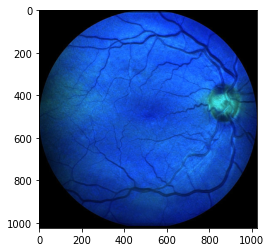

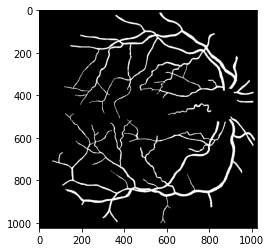

(2, 1024, 1024, 3)
(2, 1024, 1024)
2
(2, 1024, 1024, 1)


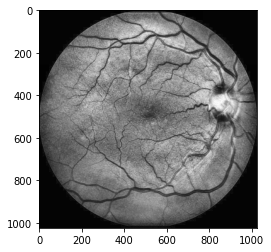

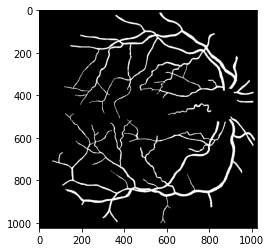

X_train shape: (2, 1024, 1024, 1)
Y_train shape: (2, 1024, 1024)
patches per full image: 500
X_train shape: (1000, 128, 128, 1)
Y_train shape: (1000, 128, 128)


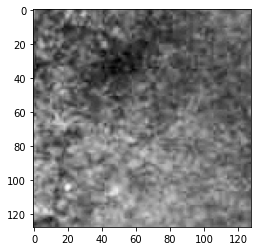

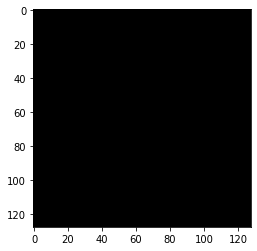

In [ ]:
#margin sampling
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import random
import numpy as np
import heapq
import pickle

from google.colab import drive
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules
from keras.callbacks import EarlyStopping
from util import *
from unet import *
from pre_processing import *
from sklearn.model_selection import train_test_split
from keras import backend as K

def margin_sampling(probability_map1, probability_map2):
  deduction = probability_map1 - probability_map2
  #print(deduction.shape)
  return np.round(np.mean(abs(deduction)),6)

def least_confidence(probability_map1, probability_map2):
  #next step is equal to 1 - np.minimumprobability_map1, probability_map2)
  least_confidence = np.minimum(probability_map1, probability_map2) 
  return np.round(np.mean(abs(least_confidence)),6)

def entropy_sampling(probability_map1, probability_map2):
  #base = 10
  item1 = np.dot(probability_map1,np.log10(probability_map1))
  item2 = np.dot(probability_map2,np.log10(probability_map2))
  sum_of_item = -(item1+item2)
  return np.mean(sum_of_item)

def EGL(probability_map1, probability_map2, grads_norm):
  item1 = probability_map1 * grads_norm
  item2 = probability_map2 * grads_norm
  item = item1 + item2
  mean_of_gradients = np.mean(item)
  return mean_of_gradients
  
if __name__ == '__main__':

  # parameters and paths
  # DRIVE resize:(576, 576)
  # HRF resize:(2920, 2920)
  # IOSTAR resize:(1024, 1024)
  resize_height, resize_width = (1024, 1024)
  # DRIVE patch size:48
  # HRF patch size:292
  # IOSTAR resize:64
  dx = 128
  # dataset option: DRIVE, HRF and IOSTAR
  dataset = "IOSTAR"

  img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
  label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

  # read the data and resize them
  imglst,images = read_image_and_name(img_path)
  labellst,labels = read_label_and_name(label_path)
  
  # pre selected annotated samples by active learning(inside 20 training images)
  # range [2, 6, 10, 14, 18, 20] , 6, 10, 14, 18, 22
  selected_image_nums = [2]  #it could be gained by percent as well, like int(0.5*len(data))

  #set the name of method will be used, selective options
  #margin_sampling, least_confidence, entropy_sampling, excepted_gradient_length, random_sampling
  #, "least_confidence", "entropy_sampling", "excepted_gradient_length", "random_sampling"
  methods = ["margin_sampling"]

  for method in methods:
    for selected_image_num in selected_image_nums:

      # randomly selected N(stored inside the variable imglst) samples from the training dataset
      print(len(images))
      image_index = [i for i in range(len(images))];
      sample_index = random.sample(image_index, selected_image_num);
      print(sample_index)
      sample_data = [images[i] for i in sample_index]
      sample_label = [labels[i] for i in sample_index]
      
      #check if the order of images and labels is not corresponding
      plt.figure()
      plt.imshow(sample_data[1])
      plt.show()

      plt.figure()
      plt.imshow(sample_label[1],'gray')
      plt.show()

      imgs_resize = resize(sample_data,resize_height,resize_width)
      labels_resize = resize(sample_label,resize_height,resize_width)

      # convert the list imgs and manuals to the numpy array
      X_train = np.array(imgs_resize)
      Y_train = np.array(labels_resize)
      print(X_train.shape)
      print(Y_train.shape)


      # do the standardization to the image, each pixel value will be
      # restricted within 0 to 1
      X_train = X_train.astype('float32')/255
      Y_train = Y_train.astype('float32')/255

      # do the pre-processing operations to the training images
      X_train = my_PreProc(X_train)

      print(X_train.shape)
      plt.figure()
      plt.imshow(X_train[1,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[1,:,:],'gray')
      plt.show()


      print('X_train shape: ' + str(X_train.shape))  # X_train(2880,48,48)
      print('Y_train shape: ' + str(Y_train.shape))  # Y_train(2880,48,48)

      # crop training images
      patches_num = 500;       #required patches num  1000

      X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*selected_image_num)
      print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
      print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)
      
      #Save a sample of what you're feeding to the neural network
      N_sample = min(X_train.shape[0],40)
      temp_Ytrain = Y_train[...,np.newaxis]
      #visualize(,'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(X_train[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(temp_Ytrain[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_output_imgs')


      plt.figure()
      plt.imshow(X_train[12,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[12,:,:],'gray')
      plt.show()

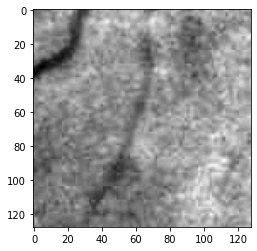

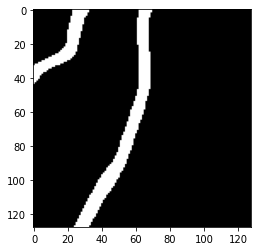

In [ ]:
plt.figure()
plt.imshow(X_train[70,:,:,0],'gray')
plt.show()

plt.figure()
plt.imshow(Y_train[70,:,:],'gray')
plt.show()

In [ ]:
print(imglst)
print(labellst)

['/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 01_OSC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 02_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 03_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 05_ODC.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 06_ODN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 08_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 09_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 10_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 13_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 15_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 16_OSN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 17_ODN.jpg', '/content/drive/MyDrive/MyProject/IOSTAR/training/images/STAR 20_ODC.jpg', '/content/drive/MyDrive/

In [ ]:
#copy cudnn files to corresponding folder
!sudo cp /content/drive/MyDrive/cuda/include/* /usr/local/cuda-11.0/include/
!sudo cp /content/drive/MyDrive/cuda/lib64/* /usr/local/cuda-11.0/lib64/
!sudo chmod a+r /usr/local/cuda-11.0/include/cudnn.h
!sudo chmod a+r /usr/local/cuda-11.0/lib64/libcudnn*

In [ ]:
#two orders need to be executed inside the command, otherwise it will not work
!export PATH=/usr/local/cuda-11.0/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin
!export LD_LIBRARY_PATH=/usr/local/cuda-11.0/lib64/
!export LIBRARY_PATH=/usr/local/cuda-11.0/lib64/stubs

In [ ]:
#margin sampling
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import random
import numpy as np
import heapq
import pickle

from google.colab import drive
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules
from keras.callbacks import EarlyStopping
from util import *
from unet import *
from pre_processing import *
from sklearn.model_selection import train_test_split
from keras import backend as K

def margin_sampling(probability_map1, probability_map2):
  maximum_probs = np.maximum(probability_map1, probability_map2)
  minimum_probs = np.minimum(probability_map1, probability_map2)
  deduction = maximum_probs - minimum_probs
  #print(deduction.shape)
  #calculate the Euclidean Distance
  return np.round(np.sqrt(np.sum(np.square(deduction))),6)

def least_confidence(probability_map1, probability_map2):
  #next step is equal to 1 - np.minimumprobability_map1, probability_map2)
  least_confidence = 1 - np.maximum(probability_map1, probability_map2)
  #calculate the Euclidean Distance 
  return np.round(np.sqrt(np.sum(np.square(least_confidence))),6)

def entropy_sampling(probability_map1, probability_map2):
  #base = 10
  item1 = np.multiply(probability_map1,np.log10(probability_map1))
  item2 = np.multiply(probability_map2,np.log10(probability_map2))
  sum_of_item = -(item1+item2)
  #calculate the Euclidean Distance
  return np.round(np.sqrt(np.sum(np.square(sum_of_item))),6)

def EGL(probability_map1, probability_map2, grads_norm):
  item1 = probability_map1 * grads_norm
  item2 = probability_map2 * grads_norm
  item = item1 + item2
  return np.mean(item)

def tversky(y_true, y_pred, smooth=1):
  y_true_pos = K.flatten(y_true)
  y_pred_pos = K.flatten(y_pred)
  true_pos = K.sum(y_true_pos * y_pred_pos)
  false_neg = K.sum(y_true_pos * (1-y_pred_pos))
  false_pos = K.sum((1-y_true_pos)*y_pred_pos)
  alpha = 0.5
  return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
  return 1 - tversky(y_true, y_pred, smooth=1)
  
if __name__ == '__main__':

  # parameters and paths
  # DRIVE resize:(576, 576)
  # HRF resize:(2920, 2920)
  # IOSTAR resize:(1024, 1024)
  resize_height, resize_width = (1472, 2176)
  # DRIVE patch size:48
  # HRF patch size:292
  # IOSTAR resize:64
  dx = 64
  # dataset option: DRIVE, HRF and IOSTAR
  dataset = "HRF"

  img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
  label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

  # read the data and resize them
  imglst,images = read_image_and_name(img_path)
  labellst,labels = read_label_and_name(label_path)
  
  # pre selected annotated samples by active learning(inside 20 training images)
  # range [2, 6, 10, 14, 18, 20] , 6, 10, 14, 18 
  selected_image_nums = [2, 6, 10, 14, 18, 20]  #it could be gained by percent as well, like int(0.5*len(data))

  #set the name of method will be used, selective options
  #margin_sampling, least_confidence, entropy_sampling, excepted_gradient_length, random_sampling
  #"least_confidence", "entropy_sampling", "excepted_gradient_length", , "random_sampling"  "margin_sampling", "least_confidence", "entropy_sampling", "excepted_gradient_length",
  methods = ["margin_sampling", "least_confidence", "entropy_sampling", "excepted_gradient_length", "random_sampling"]

  # randomly selected N(stored inside the variable imglst) samples from the training dataset
  # due to the uncertainty of accuracy from the initialized classifier, take labeled data in advance
  selected_data_set = []
  selected_label_set = []
  sample_index_set = []
  image_index = [i for i in range(len(images))]
  for selected_image_num in selected_image_nums:
    sample_index = random.sample(image_index, selected_image_num)
    sample_data = [images[i] for i in sample_index]
    sample_label = [labels[i] for i in sample_index]
    selected_data_set.append(sample_data)
    selected_label_set.append(sample_label)
    sample_index_set.append(sample_index)

  for method in methods:
    for selected_index, selected_item in enumerate(selected_image_nums):
      sample_data = selected_data_set[selected_index]
      sample_label = selected_label_set[selected_index]
      sample_index = sample_index_set[selected_index]
      
      #check if the order of images and labels is not corresponding
      plt.figure()
      plt.imshow(sample_data[1])
      plt.show()

      plt.figure()
      plt.imshow(sample_label[1],'gray')
      plt.show()

      imgs_resize = resize(sample_data,resize_width,resize_height)
      labels_resize = resize(sample_label,resize_width,resize_height)

      # convert the list imgs and manuals to the numpy array
      X_train = np.array(imgs_resize)
      Y_train = np.array(labels_resize)
      print(X_train.shape)
      print(Y_train.shape)


      # do the standardization to the image, each pixel value will be
      # restricted within 0 to 1
      X_train = X_train.astype('float32')/255
      Y_train = Y_train.astype('float32')/255

      # do the pre-processing operations to the training images
      X_train = my_PreProc(X_train)

      print(X_train.shape)
      plt.figure()
      plt.imshow(X_train[1,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[1,:,:],'gray')
      plt.show()

      print('X_train shape: ' + str(X_train.shape))  # X_train(2880,48,48)
      print('Y_train shape: ' + str(Y_train.shape))  # Y_train(2880,48,48)

      # crop training images
      patches_num = 300;       #required patches num 1000

      X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*selected_image_num)
      print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
      print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)
      
      """
      #Save a sample of what you're feeding to the neural network
      N_sample = min(X_train.shape[0],40)
      temp_Ytrain = Y_train[...,np.newaxis]
      #visualize(,'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(X_train[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(temp_Ytrain[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_output_imgs')
      """

      plt.figure()
      plt.imshow(X_train[12,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[12,:,:],'gray')
      plt.show()
      
      # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
      X_train = X_train[:,np.newaxis, ...]
      print('X_train shape: '+str(X_train.shape))
      # change the shape of Y_train, make it become (2880,2304), keep the first dimension
      # unchanged, merge other dimensions
      Y_train = Y_train.reshape(Y_train.shape[0],-1)
      print('Y_train shape: '+str(Y_train.shape))
      # increase one dimension, make it become (2880,2304,1)
      Y_train =Y_train[..., np.newaxis]
      print('Y_train shape: '+str(Y_train.shape))
      temp = 1 - Y_train
      # make it become (2880,2304,2)
      Y_train = np.concatenate([Y_train, temp], axis=2)
      print('Y_train shape: '+str(Y_train.shape))
      print('X_train shape: '+str(X_train.shape))
      
      
      # model is gained
      n_label = 2   #number of classes
      model = None
      model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

      #set early stopping to prevent overfit
      early_stopping = EarlyStopping(monitor='loss',patience=3,verbose=2)
      
      model.summary()  # output the calculation process of parameter Param
      checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+
                                      ').h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
      
      model.compile(optimizer=Adam(lr=0.0005),loss='categorical_crossentropy',metrics=['accuracy']) 


      #split 80% for training and 20% for validation
      seed = 7
      np.random.seed(seed)
      X_trainset, X_testset, Y_trainset, Y_testset = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

      history1 = model.fit(X_trainset,Y_trainset,batch_size=64,epochs=10,verbose=2,shuffle=True,validation_data=(X_testset, Y_testset),callbacks=[checkpointer,early_stopping])
      
      # use the uncertainty and fine-tuning to train this model
      training_samples_num = selected_item * patches_num
      # patches number extracted from unlabeled images
      unlabeled_patches_num = 100

      active_indice = [i for i in image_index if i not in sample_index]
      print("active_indice:"+str(len(active_indice)))

      final_new_train_samples = X_trainset
      final_new_train_labels = Y_trainset

      epochs = 0

      #start the for-loop from here
      #while len(active_indice) != 0:
      #a = 1
      #while a == 1:

      #a = 1
      while len(active_indice) != 0:
          
        active_image_data = [images[i] for i in active_indice]
        active_image_label = [labels[i] for i in active_indice]

        active_imgs_resize = resize(active_image_data,resize_width,resize_height)
        active_labels_resize = resize(active_image_label,resize_width,resize_height)

        #extract patches from unlabeled images again, take their labels meanwhile
        #convert the list imgs and manuals to the numpy array
        active_X_train = np.array(active_imgs_resize)
        active_Y_train = np.array(active_labels_resize)

        # do the standardization to the image, each pixel value will be
        # restricted within 0 to 1
        active_X_train = active_X_train.astype('float32')/255
        active_Y_train = active_Y_train.astype('float32')/255

        # do the pre-processing operations to the training images
        active_X_train = my_PreProc(active_X_train)
        print('active_X_train shape: '+str(active_X_train.shape)) 
        print('active_Y_train shape: '+str(active_Y_train.shape))
        
        sample_confidence = []
        if method is not "random_sampling":
          #active_samples_num = len(active_indice) * unlabeled_patches_num
          for k in range(active_X_train.shape[0]):   
            list1 = []
            list2 = []
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                list1.append(active_X_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
                list2.append(active_Y_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
            
            active_prediction_samples = np.array(list1)[:,np.newaxis,...] #increase one dimension, it will become (144,1,48,48)
            active_groundtruth_samples = np.array(list2)[:,np.newaxis,...]
            #print('active_X_train shape: '+str(active_prediction_samples.shape)) 
            #print('active_Y_train shape: '+str(active_Y_train.shape))

            #print(new_X_train.shape)
            Y_pred_train = model.predict(active_prediction_samples)
            #print('predict shape: '+str(Y_pred_train.shape))

            Y_pred1 = Y_pred_train[...,0]
            Y_pred2 = Y_pred_train[...,1]

            probability_map1 = np.zeros((resize_height, resize_width))
            probability_map2 = np.zeros((resize_height, resize_width))

            t = 0
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                temp1 = Y_pred1[t].reshape(dx, dx)
                temp2 = Y_pred2[t].reshape(dx, dx)
                probability_map1[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp1
                probability_map2[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp2
                t = t + 1
            
            probability_map1 = cv2.resize(probability_map1,(resize_height,resize_width))
            probability_map2 = cv2.resize(probability_map2,(resize_height,resize_width))
            
            #output one to see the probability
            #print('probability:'+str(Y_pred_train[1,:,0]))
            #print('probability:'+str(Y_pred_train[1,:,1]))

            #calculate every unannotated image's uncertainty
            #S = np.round(compute_matrix(Y_pred_train, 0, 1, 1),2)
            if method == "margin_sampling":
              S = margin_sampling(probability_map1, probability_map2)
            elif method == "least_confidence":
              S = least_confidence(probability_map1, probability_map2)
            elif method == "entropy_sampling":
              S = entropy_sampling(probability_map1, probability_map2)
            elif method == "excepted_gradient_length":
              real_y = active_groundtruth_samples
              real_y = real_y.reshape(real_y.shape[0],-1)
              real_y = real_y[...,np.newaxis]
              temp = 1 - real_y
              real_y = np.concatenate([real_y, temp], axis=2)
              
              with tf.GradientTape() as tape:
                cce = tf.keras.losses.CategoricalCrossentropy()
                pred_y = model(active_prediction_samples)
                ce_loss = cce(real_y, pred_y)
              
              grads = tape.gradient(ce_loss,model.trainable_variables)
              grads_norm = 0
              #print(len(grads))
              for i in range(len(grads)):
                grads_norm = grads_norm + np.linalg.norm(x=grads[i].numpy().flatten(),ord=2)
              #print(grads_norm)
              S = EGL(probability_map1, probability_map2, grads_norm)

            sample_confidence.append(S)
            
        #print(active_scores)
        print(sample_confidence)

        #sample_confidence:convert list to array
        sample_confidence = np.array(sample_confidence)
        
        #smallest_index = [index for index,value in enumerate(sample_confidence) if value==min(sample_confidence)]
        #find the elements with lowest/highest active scores
        smallest_index = []
        selected_num = 2 #2 3
        if method == "random_sampling":
          current_active_indice = [i for i in range(len(active_indice))];
          if len(current_active_indice)<selected_num:
            smallest_index = random.sample(current_active_indice, len(current_active_indice))
          else:
            smallest_index = random.sample(current_active_indice, selected_num)
        elif method == "margin_sampling":
          sorts = np.argsort(sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "least_confidence":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "entropy_sampling":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "excepted_gradient_length":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        
        print(smallest_index)
        
        smallest_elements = [active_X_train[i] for i in smallest_index]
        smallest_labels = [active_Y_train[i] for i in smallest_index]

        reshaped_elements = []
        reshaped_labels = []
        for tuning_item, tuning_label in zip(smallest_elements, smallest_labels):
          item = [tuning_item]
          label = [tuning_label]
          tuning_item = resize(item,resize_width,resize_height)
          tuning_label = resize(label,resize_width,resize_height)

          tuning_item = np.array(tuning_item)
          tuning_label = np.array(tuning_label)

          #smallest_elements, smallest_labels = extract_random(smallest_elements, smallest_labels, dx, dx, unlabeled_patches_num*len(smallest_index))
          
          temp_elements = []
          temp_labels = []
          for a, b in zip(tuning_item, tuning_label):
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                temp_elements.append(a[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
                temp_labels.append(b[i*dx:(i+1)*dx, j*dx:(j+1)*dx])

          temp_elements = np.array(temp_elements)[:,np.newaxis,...,np.newaxis]
          temp_labels = np.array(temp_labels)[:,...,np.newaxis]

          reshaped_elements.append(temp_elements)
          reshaped_labels.append(temp_labels)

        smallest_elements = np.concatenate(reshaped_elements, axis=0)
        smallest_labels = np.concatenate(reshaped_labels, axis=0)
        print(smallest_elements.shape)
        print(smallest_labels.shape)

        #smallest_elements = smallest_elements[..., np.newaxis]

        # change the shape of Y_train, make it become (2880,2304), keep the first dimension
        # unchanged, merge other dimensions
        smallest_labels = smallest_labels.reshape(smallest_labels.shape[0],-1)
        print('smallest_labels shape: '+str(smallest_labels.shape))
        # increase one dimension, make it become (2880,2304,1)
        smallest_labels = smallest_labels[..., np.newaxis]
        print('Y_train shape: '+str(Y_train.shape))
        temp = 1 - smallest_labels
        # make it become (2880,2304,2)
        smallest_labels = np.concatenate([smallest_labels, temp], axis=2)

        print(smallest_elements.shape)
        print(smallest_labels.shape)          
        

        new_train_samples = []
        for i in range(final_new_train_samples.shape[0]):
          ori_element = final_new_train_samples[i,...]
          new_train_samples.append(ori_element[np.newaxis,:])
        for j in range(smallest_elements.shape[0]):
          new_element = smallest_elements[j,...]
          new_train_samples.append(new_element[np.newaxis,:])
        final_new_train_samples = np.concatenate(new_train_samples,axis=0)
        
        new_train_labels = []
        for i in range(final_new_train_labels.shape[0]):
          ori_label = final_new_train_labels[i,...]
          new_train_labels.append(ori_label[np.newaxis,:])
        for j in range(smallest_labels.shape[0]):
          new_label = smallest_labels[j,...]
          new_train_labels.append(new_label[np.newaxis,:])
        final_new_train_labels = np.concatenate(new_train_labels,axis=0)

        print('final_new_train_samples shape: '+str(final_new_train_samples.shape))
        print('final_new_train_labels shape: '+str(final_new_train_labels.shape))
      
        # use these 100 the most uncertain samples 
        # to do the fine-tuning to this network
        print("Use the pre trained model for fine tuning")
        print(model.layers)

        for layer in model.layers[:10]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        for layer in model.layers[21:30]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        
        print(len(model.layers))

        #set early stopping to prevent overfit
        #early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)

        #model.summary()  # output the calculation process of parameter Param
        checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+
                                      ').h5',verbose=1,monitor='accuracy',mode='auto',save_best_only=True)
        model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
        history2 = model.fit(final_new_train_samples,final_new_train_labels,batch_size=64,epochs=10,verbose=2,shuffle=True,validation_split=0.0,callbacks=[checkpointer,early_stopping]) #,early_stopping

        #update corresponding parameters
        ruleout_list = [active_indice[i] for i in smallest_index]
        active_indice = [x for x in active_indice if x not in ruleout_list]
        print(active_indice)
        active_samples_num = len(active_indice)*patches_num

        # draw corresponding loss figures
        history1.history['accuracy'].extend(history2.history['accuracy'])
        history1.history['loss'].extend(history2.history['loss'])
        
      #print(history1.history['accuracy'])
      #print(history1.history['loss'])

      #mode wb+ readable and writable, and files will be automatically created if they don't exist
      #binary mode
      with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_'+str(selected_item)+'.txt','wb+') as file_pi:
        pickle.dump(history1.history, file_pi)

Output hidden; open in https://colab.research.google.com to view.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_01L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_02L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_03L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_04L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_05L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_06L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_07L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_08L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_09L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_10L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/training/images/Image_11L.jpg', '/content/drive/MyDrive/MyProject/CHASEDB1/tr

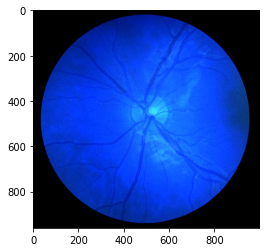

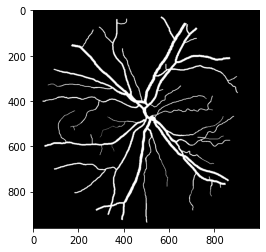

(2, 960, 999, 3)
(2, 960, 999)
2
(2, 960, 999, 1)


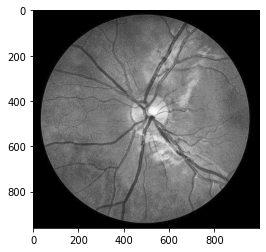

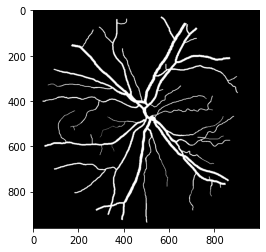

X_train shape: (2, 960, 999, 1)
Y_train shape: (2, 960, 999)
patches per full image: 600
X_train shape: (1200, 32, 32, 1)
Y_train shape: (1200, 32, 32)


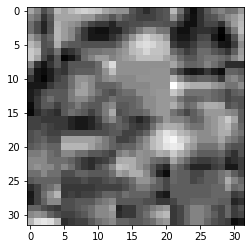

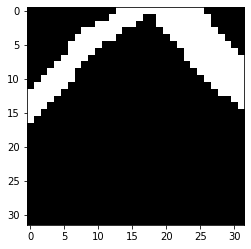

X_train shape: (1200, 1, 32, 32, 1)
Y_train shape: (1200, 1024)
Y_train shape: (1200, 1024, 1)
Y_train shape: (1200, 1024, 2)
X_train shape: (1200, 1, 32, 32, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 32, 32)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)              

KeyboardInterrupt: ignored

In [1]:
#margin sampling
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import random
import numpy as np
import heapq
import pickle

from google.colab import drive
drive.mount('/content/drive') #authorize google drive
sys.path.append('/content/drive/MyDrive/MyProject/') #the storage path of my own modules
from keras.callbacks import EarlyStopping
from util import *
from unet import *
from pre_processing import *
from sklearn.model_selection import train_test_split
from keras import backend as K

def margin_sampling(probability_map1, probability_map2):
  maximum_probs = np.maximum(probability_map1, probability_map2)
  minimum_probs = np.minimum(probability_map1, probability_map2)
  deduction = maximum_probs - minimum_probs
  #print(deduction.shape)
  #calculate the Euclidean Distance
  return np.round(np.sqrt(np.sum(np.square(deduction))),6)

def least_confidence(probability_map1, probability_map2):
  #next step is equal to 1 - np.minimumprobability_map1, probability_map2)
  least_confidence = 1 - np.maximum(probability_map1, probability_map2)
  #calculate the Euclidean Distance 
  return np.round(np.sqrt(np.sum(np.square(least_confidence))),6)

def entropy_sampling(probability_map1, probability_map2):
  #base = 10
  item1 = np.dot(probability_map1,np.log10(probability_map1))
  item2 = np.dot(probability_map2,np.log10(probability_map2))
  sum_of_item = -(item1+item2)
  #calculate the Euclidean Distance
  return np.round(np.sqrt(np.sum(np.square(sum_of_item))),6)

def EGL(probability_map1, probability_map2, grads_norm):
  item1 = probability_map1 * grads_norm
  item2 = probability_map2 * grads_norm
  item = item1 + item2
  return np.round(np.sqrt(np.sum(np.square(item))),6)

def tversky(y_true, y_pred, smooth=1):
  y_true_pos = K.flatten(y_true)
  y_pred_pos = K.flatten(y_pred)
  true_pos = K.sum(y_true_pos * y_pred_pos)
  false_neg = K.sum(y_true_pos * (1-y_pred_pos))
  false_pos = K.sum((1-y_true_pos)*y_pred_pos)
  alpha = 0.5
  return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
  return 1 - tversky(y_true, y_pred, smooth=1)
  
if __name__ == '__main__':

  # parameters and paths
  # DRIVE resize:(576, 576)
  # HRF resize:(2920, 2920)
  # IOSTAR resize:(1024, 1024)
  resize_height, resize_width = (992, 992)
  # DRIVE patch size:48
  # HRF patch size:292
  # IOSTAR resize:64
  dx = 32
  # dataset option: DRIVE, HRF and IOSTAR
  dataset = "CHASEDB1"

  img_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/images/'
  label_path = '/content/drive/MyDrive/MyProject/'+dataset+'/training/1st_manual/'

  # read the data and resize them
  imglst,images = read_image_and_name(img_path)
  labellst,labels = read_label_and_name(label_path)
  
  # pre selected annotated samples by active learning(inside 20 training images)
  # range [2, 6, 10, 14, 18, 20]  [2, 6, 10, 14, 18]
  selected_image_nums = [2]  #it could be gained by percent as well, like int(0.5*len(data))

  #set the name of method will be used, selective options
  #margin_sampling, least_confidence, entropy_sampling, excepted_gradient_length, random_sampling
  #"random_sampling"  "margin_sampling", "least_confidence", "entropy_sampling", "excepted_gradient_length", 
  methods = ["margin_sampling"]

  # randomly selected N(stored inside the variable imglst) samples from the training dataset
  # due to the uncertainty of accuracy from the initialized classifier, take labeled data in advance
  selected_data_set = []
  selected_label_set = []
  sample_index_set = []
  image_index = [i for i in range(len(images))]
  for selected_image_num in selected_image_nums:
    sample_index = random.sample(image_index, selected_image_num)
    sample_data = [images[i] for i in sample_index]
    sample_label = [labels[i] for i in sample_index]
    selected_data_set.append(sample_data)
    selected_label_set.append(sample_label)
    sample_index_set.append(sample_index)

  for method in methods:
    for selected_index, selected_item in enumerate(selected_image_nums):
      sample_data = selected_data_set[selected_index]
      sample_label = selected_label_set[selected_index]
      sample_index = sample_index_set[selected_index]
      
      #check if the order of images and labels is not corresponding
      plt.figure()
      plt.imshow(sample_data[1])
      plt.show()

      plt.figure()
      plt.imshow(sample_label[1],'gray')
      plt.show()

      #imgs_resize = resize(sample_data,resize_width,resize_height)
      #labels_resize = resize(sample_label,resize_width,resize_height)

      # convert the list imgs and manuals to the numpy array
      X_train = np.array(sample_data)
      Y_train = np.array(sample_label)
      print(X_train.shape)
      print(Y_train.shape)


      # do the standardization to the image, each pixel value will be
      # restricted within 0 to 1
      X_train = X_train.astype('float32')/255
      Y_train = Y_train.astype('float32')/255

      # do the pre-processing operations to the training images
      X_train = my_PreProc(X_train)

      print(X_train.shape)
      plt.figure()
      plt.imshow(X_train[1,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[1,:,:],'gray')
      plt.show()

      print('X_train shape: ' + str(X_train.shape))  # X_train(2880,48,48)
      print('Y_train shape: ' + str(Y_train.shape))  # Y_train(2880,48,48)

      # crop training images
      patches_num = 600;       #required patches num 1000

      X_train, Y_train = extract_random(X_train, Y_train, dx, dx, patches_num*selected_image_num)
      print('X_train shape: '+str(X_train.shape)) #X_train(2880,48,48)
      print('Y_train shape: '+str(Y_train.shape)) #Y_train(2880,48,48)
      
      
      #Save a sample of what you're feeding to the neural network
      N_sample = min(X_train.shape[0],40)
      temp_Ytrain = Y_train[...,np.newaxis]
      #visualize(,'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(X_train[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_input_imgs')
      visualize(group_images(temp_Ytrain[0:N_sample,:,:,:],5),'/content/drive/MyDrive/MyProject/'+dataset+'/samples/sample_output_imgs')


      plt.figure()
      plt.imshow(X_train[12,:,:,0],'gray')
      plt.show()

      plt.figure()
      plt.imshow(Y_train[12,:,:],'gray')
      plt.show()
      
      # Increase one dimension to X_train, the dimension will become (2880,1,48,48)
      X_train = X_train[:,np.newaxis, ...]
      print('X_train shape: '+str(X_train.shape))
      # change the shape of Y_train, make it become (2880,2304), keep the first dimension
      # unchanged, merge other dimensions
      Y_train = Y_train.reshape(Y_train.shape[0],-1)
      print('Y_train shape: '+str(Y_train.shape))
      # increase one dimension, make it become (2880,2304,1)
      Y_train =Y_train[..., np.newaxis]
      print('Y_train shape: '+str(Y_train.shape))
      temp = 1 - Y_train
      # make it become (2880,2304,2)
      Y_train = np.concatenate([Y_train, temp], axis=2)
      print('Y_train shape: '+str(Y_train.shape))
      print('X_train shape: '+str(X_train.shape))
      
      
      # model is gained
      n_label = 2   #number of classes
      model = None
      model = get_unet(X_train.shape[1],X_train.shape[2],X_train.shape[3],n_label)

      #set early stopping to prevent overfit
      early_stopping = EarlyStopping(monitor='loss',patience=3,verbose=2)
      
      model.summary()  # output the calculation process of parameter Param
      checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+
                                      ').h5',verbose=1,monitor='val_accuracy',mode='auto',save_best_only=True)
      
      model.compile(optimizer=Adam(lr=0.0005),loss='categorical_crossentropy',metrics=['accuracy']) 


      #split 80% for training and 20% for validation
      seed = 7
      np.random.seed(seed)
      X_trainset, X_testset, Y_trainset, Y_testset = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

      history1 = model.fit(X_trainset,Y_trainset,batch_size=64,epochs=10,verbose=2,shuffle=True,validation_data=(X_testset, Y_testset),callbacks=[checkpointer,early_stopping])
      
      # use the uncertainty and fine-tuning to train this model
      training_samples_num = selected_item * patches_num
      # patches number extracted from unlabeled images
      unlabeled_patches_num = 100

      active_indice = [i for i in image_index if i not in sample_index]
      print("active_indice:"+str(len(active_indice)))

      final_new_train_samples = X_trainset
      final_new_train_labels = Y_trainset

      epochs = 0

      #start the for-loop from here
      #while len(active_indice) != 0:
      #a = 1
      #while a == 1:

      #a = 1
      while len(active_indice) != 0:
          
        active_image_data = [images[i] for i in active_indice]
        active_image_label = [labels[i] for i in active_indice]

        active_imgs_resize = resize(active_image_data,resize_width,resize_height)
        active_labels_resize = resize(active_image_label,resize_width,resize_height)

        #extract patches from unlabeled images again, take their labels meanwhile
        #convert the list imgs and manuals to the numpy array
        active_X_train = np.array(active_imgs_resize)
        active_Y_train = np.array(active_labels_resize)

        # do the standardization to the image, each pixel value will be
        # restricted within 0 to 1
        active_X_train = active_X_train.astype('float32')/255
        active_Y_train = active_Y_train.astype('float32')/255

        # do the pre-processing operations to the training images
        active_X_train = my_PreProc(active_X_train)
        print('active_X_train shape: '+str(active_X_train.shape)) 
        print('active_Y_train shape: '+str(active_Y_train.shape))
        
        sample_confidence = []
        if method is not "random_sampling":
          #active_samples_num = len(active_indice) * unlabeled_patches_num
          for k in range(active_X_train.shape[0]):   
            list1 = []
            list2 = []
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                list1.append(active_X_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
                list2.append(active_Y_train[k,...][i*dx:(i+1)*dx, j*dx:(j+1)*dx])
            active_prediction_samples = np.array(list1)[:,np.newaxis,...] #increase one dimension, it will become (144,1,48,48)
            active_groundtruth_samples = np.array(list2)[:,np.newaxis,...]
            #print('active_X_train shape: '+str(active_prediction_samples.shape)) 
            #print('active_Y_train shape: '+str(active_Y_train.shape))

            #print(new_X_train.shape)
            Y_pred_train = model.predict(active_prediction_samples)
            #print('predict shape: '+str(Y_pred_train.shape))

            Y_pred1 = Y_pred_train[...,0]
            Y_pred2 = Y_pred_train[...,1]

            probability_map1 = np.zeros((resize_height, resize_width))
            probability_map2 = np.zeros((resize_height, resize_width))

            t = 0
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                temp1 = Y_pred1[t].reshape(dx, dx)
                temp2 = Y_pred2[t].reshape(dx, dx)
                probability_map1[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp1
                probability_map2[i*dx:(i+1)*dx, j*dx:(j+1)*dx] = temp2
                t = t + 1
            
            probability_map1 = cv2.resize(probability_map1,(resize_height,resize_width))
            probability_map2 = cv2.resize(probability_map2,(resize_height,resize_width))
            
            #output one to see the probability
            #print('probability:'+str(Y_pred_train[1,:,0]))
            #print('probability:'+str(Y_pred_train[1,:,1]))

            #calculate every unannotated image's uncertainty
            #S = np.round(compute_matrix(Y_pred_train, 0, 1, 1),2)
            if method == "margin_sampling":
              S = margin_sampling(probability_map1, probability_map2)
            elif method == "least_confidence":
              S = least_confidence(probability_map1, probability_map2)
            elif method == "entropy_sampling":
              S = entropy_sampling(probability_map1, probability_map2)
            elif method == "excepted_gradient_length":
              real_y = active_groundtruth_samples
              real_y = real_y.reshape(real_y.shape[0],-1)
              real_y = real_y[...,np.newaxis]
              temp = 1 - real_y
              real_y = np.concatenate([real_y, temp], axis=2)
              
              with tf.GradientTape() as tape:
                cce = tf.keras.losses.CategoricalCrossentropy()
                pred_y = model(active_prediction_samples)
                ce_loss = cce(real_y, pred_y)
              
              grads = tape.gradient(ce_loss,model.trainable_variables)
              grads_norm = 0
              #print(len(grads))
              for i in range(len(grads)):
                grads_norm = grads_norm + np.linalg.norm(x=grads[i].numpy().flatten(),ord=2)
              #print(grads_norm)
              S = EGL(probability_map1, probability_map2, grads_norm)

            sample_confidence.append(S)
            
        #print(active_scores)
        print(sample_confidence)

        #sample_confidence:convert list to array
        sample_confidence = np.array(sample_confidence)
        
        #smallest_index = [index for index,value in enumerate(sample_confidence) if value==min(sample_confidence)]
        #find the elements with lowest/highest active scores
        smallest_index = []
        selected_num = 2 #2 3
        if method == "random_sampling":
          current_active_indice = [i for i in range(len(active_indice))];
          if len(current_active_indice)<selected_num:
            smallest_index = random.sample(current_active_indice, len(current_active_indice))
          else:
            smallest_index = random.sample(current_active_indice, selected_num)
        elif method == "margin_sampling":
          sorts = np.argsort(sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "least_confidence":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "entropy_sampling":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        elif method == "excepted_gradient_length":
          sorts = np.argsort(-sample_confidence)
          if len(sorts) < selected_num:
            smallest_index = sorts
          else:
            smallest_index = sorts[0:selected_num]
        
        print(smallest_index)
        
        smallest_elements = [active_X_train[i] for i in smallest_index]
        smallest_labels = [active_Y_train[i] for i in smallest_index]

        reshaped_elements = []
        reshaped_labels = []
        for tuning_item, tuning_label in zip(smallest_elements, smallest_labels):
          item = [tuning_item]
          label = [tuning_label]
          tuning_item = resize(item,resize_width,resize_height)
          tuning_label = resize(label,resize_width,resize_height)

          tuning_item = np.array(tuning_item)
          tuning_label = np.array(tuning_label)

          #smallest_elements, smallest_labels = extract_random(smallest_elements, smallest_labels, dx, dx, unlabeled_patches_num*len(smallest_index))
          
          temp_elements = []
          temp_labels = []
          for a, b in zip(tuning_item, tuning_label):
            for i in range(resize_height//dx):
              for j in range(resize_width//dx):
                temp_elements.append(a[i*dx:(i+1)*dx, j*dx:(j+1)*dx])
                temp_labels.append(b[i*dx:(i+1)*dx, j*dx:(j+1)*dx])

          temp_elements = np.array(temp_elements)[:,np.newaxis,...,np.newaxis]
          temp_labels = np.array(temp_labels)[:,...,np.newaxis]

          reshaped_elements.append(temp_elements)
          reshaped_labels.append(temp_labels)

        smallest_elements = np.concatenate(reshaped_elements, axis=0)
        smallest_labels = np.concatenate(reshaped_labels, axis=0)
        print(smallest_elements.shape)
        print(smallest_labels.shape)

        #smallest_elements = smallest_elements[..., np.newaxis]

        # change the shape of Y_train, make it become (2880,2304), keep the first dimension
        # unchanged, merge other dimensions
        smallest_labels = smallest_labels.reshape(smallest_labels.shape[0],-1)
        print('smallest_labels shape: '+str(smallest_labels.shape))
        # increase one dimension, make it become (2880,2304,1)
        smallest_labels = smallest_labels[..., np.newaxis]
        print('Y_train shape: '+str(Y_train.shape))
        temp = 1 - smallest_labels
        # make it become (2880,2304,2)
        smallest_labels = np.concatenate([smallest_labels, temp], axis=2)

        print(smallest_elements.shape)
        print(smallest_labels.shape)          
        

        new_train_samples = []
        for i in range(final_new_train_samples.shape[0]):
          ori_element = final_new_train_samples[i,...]
          new_train_samples.append(ori_element[np.newaxis,:])
        for j in range(smallest_elements.shape[0]):
          new_element = smallest_elements[j,...]
          new_train_samples.append(new_element[np.newaxis,:])
        final_new_train_samples = np.concatenate(new_train_samples,axis=0)
        
        new_train_labels = []
        for i in range(final_new_train_labels.shape[0]):
          ori_label = final_new_train_labels[i,...]
          new_train_labels.append(ori_label[np.newaxis,:])
        for j in range(smallest_labels.shape[0]):
          new_label = smallest_labels[j,...]
          new_train_labels.append(new_label[np.newaxis,:])
        final_new_train_labels = np.concatenate(new_train_labels,axis=0)

        print('final_new_train_samples shape: '+str(final_new_train_samples.shape))
        print('final_new_train_labels shape: '+str(final_new_train_labels.shape))
      
        # use these 100 the most uncertain samples 
        # to do the fine-tuning to this network
        print("Use the pre trained model for fine tuning")
        print(model.layers)

        for layer in model.layers[:10]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        for layer in model.layers[21:30]:
          layer.trainable = False
          #print(layer)
          #print("these layers won't be trained")
        
        print(len(model.layers))

        #set early stopping to prevent overfit
        #early_stopping = EarlyStopping(monitor='val_loss',patience=3,verbose=2)

        #model.summary()  # output the calculation process of parameter Param
        checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+dataset+'_best_weights('+method+'_'+str(selected_item)+
                                      ').h5',verbose=1,monitor='accuracy',mode='auto',save_best_only=True)
        model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
        history2 = model.fit(final_new_train_samples,final_new_train_labels,batch_size=64,epochs=10,verbose=2,shuffle=True,validation_split=0.0,callbacks=[checkpointer,early_stopping]) #,early_stopping

        #update corresponding parameters
        ruleout_list = [active_indice[i] for i in smallest_index]
        active_indice = [x for x in active_indice if x not in ruleout_list]
        print(active_indice)
        active_samples_num = len(active_indice)*patches_num

        # draw corresponding loss figures
        history1.history['accuracy'].extend(history2.history['accuracy'])
        history1.history['loss'].extend(history2.history['loss'])
        
      #print(history1.history['accuracy'])
      #print(history1.history['loss'])

      #mode wb+ readable and writable, and files will be automatically created if they don't exist
      #binary mode
      with open('/content/drive/MyDrive/MyProject/'+dataset+'/training_records/'+method+'_'+str(selected_item)+'.txt','wb+') as file_pi:
        pickle.dump(history1.history, file_pi)

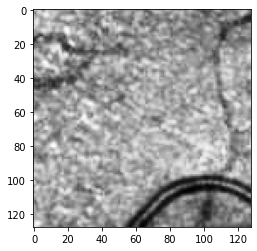

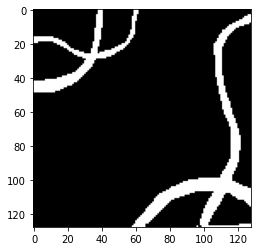

In [7]:
plt.figure()
plt.imshow(X_train[20,:,:,0],'gray')
plt.show()

plt.figure()
plt.imshow(Y_train[20,:,:],'gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')